In [1]:
###########################################################
# Imports
###########################################################

import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import HigherTierModel
import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_2_track_noPrimaries_wCutInfo_extraVar_NEW.npz')

print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_2_track_noPrimaries_wCutInfo_extraVar_NEW.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 79))
variables_test = np.empty((0, 79))

# Truth
y_train = np.empty((0, 4))
y_test = np.empty((0, 4))
trueParentChildLink_train = np.empty((0), dtype='int')
trueParentChildLink_test = np.empty((0), dtype='int')
trueChildVisibleGeneration_train = np.empty((0), dtype='int')
trueChildVisibleGeneration_test = np.empty((0), dtype='int')
trainingCutSep_train = np.empty((0), dtype='float')
trainingCutSep_test = np.empty((0), dtype='float')
trainingCutDoesConnect_train = np.empty((0), dtype='float')
trainingCutDoesConnect_test = np.empty((0), dtype='float')
trainingCutL_train = np.empty((0), dtype='float')
trainingCutL_test = np.empty((0), dtype='float')
trainingCutT_train = np.empty((0), dtype='float')
trainingCutT_test = np.empty((0), dtype='float')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    trueParentChildLink_train = np.concatenate((trueParentChildLink_train, data['trueParentChildLink_train']), axis=0)
    trueParentChildLink_test = np.concatenate((trueParentChildLink_test, data['trueParentChildLink_test']), axis=0)
    trueChildVisibleGeneration_train = np.concatenate((trueChildVisibleGeneration_train, data['trueChildVisibleGeneration_train']), axis=0)
    trueChildVisibleGeneration_test = np.concatenate((trueChildVisibleGeneration_test, data['trueChildVisibleGeneration_test']), axis=0)
    trainingCutSep_train = np.concatenate((trainingCutSep_train, data['trainingCutSep_train']), axis=0)
    trainingCutSep_test = np.concatenate((trainingCutSep_test, data['trainingCutSep_test']), axis=0)
    trainingCutDoesConnect_train = np.concatenate((trainingCutDoesConnect_train, data['trainingCutDoesConnect_train']), axis=0)
    trainingCutDoesConnect_test = np.concatenate((trainingCutDoesConnect_test, data['trainingCutDoesConnect_test']), axis=0)
    trainingCutL_train = np.concatenate((trainingCutL_train, data['trainingCutL_train']), axis=0)
    trainingCutL_test = np.concatenate((trainingCutL_test, data['trainingCutL_test']), axis=0)
    trainingCutT_train = np.concatenate((trainingCutT_train, data['trainingCutT_train']), axis=0)
    trainingCutT_test = np.concatenate((trainingCutT_test, data['trainingCutT_test']), axis=0)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_2_track_noPrimaries_wCutInfo_extraVar_NEW.npz , This may take a while...


In [21]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)

nVariables = variables_train.shape[1]
nLinks = y_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('ntrain:', ntrain)

variables_train.shape: (277259, 79)
variables_test.shape: (30640, 79)
y_train.shape: (277259, 4, 3)
y_test.shape: (30640, 4, 3)
trueParentChildLink_train.shape: (277259, 2)
trueParentChildLink_test.shape: (30640, 2)
trueChildVisibleGeneration_train.shape: (277259,)
trueChildVisibleGeneration_test.shape: (30640,)
trainingCutSep_train.shape: (277259,)
trainingCutSep_test.shape: (30640,)
trainingCutDoesConnect_train.shape: (277259,)
trainingCutDoesConnect_test.shape: (30640,)
trainingCutL_train.shape: (277259,)
trainingCutL_test.shape: (30640,)
trainingCutT_train.shape: (277259,)
trainingCutT_test.shape: (30640,)
ntrain: 277259


In [6]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_SEP = 20.0
MIN_TRAINING_CUT_L = -100.0
MAX_TRAINING_CUT_L = 100.0
MAX_TRAINING_CUT_T = 40.0

######################
# training set first
######################
# Make mask
passTrainingCutSep_train = trainingCutSep_train < MAX_TRAINING_CUT_SEP
passTrainingCutDoesConnect_train = trainingCutDoesConnect_train == 1
passTrainingCutL_train = np.logical_and(trainingCutL_train > MIN_TRAINING_CUT_L, trainingCutL_train < MAX_TRAINING_CUT_L)
passTrainingCutT_train = trainingCutT_train < MAX_TRAINING_CUT_T
# passTrainingCuts_train = np.logical_or(passTrainingCutSep_train, np.logical_and(passTrainingCutL_train, passTrainingCutT_train))
passTrainingCuts_train = np.logical_or(passTrainingCutSep_train, np.logical_or(passTrainingCutDoesConnect_train, np.logical_and(passTrainingCutL_train, passTrainingCutT_train)))

# Mask the 1D variables... shape=(nEntries, )
trueChildVisibleGeneration_train = trueChildVisibleGeneration_train[passTrainingCuts_train]
trueParentChildLink_train = trueParentChildLink_train[passTrainingCuts_train]
trainingCutSep_train = trainingCutSep_train[passTrainingCuts_train] # Don't really need to do this as we're not using them again
trainingCutDoesConnect_train = trainingCutDoesConnect_train[passTrainingCuts_train] # Don't really need to do this as we're not using them again
trainingCutL_train = trainingCutL_train[passTrainingCuts_train]     # Don't really need to do this as we're not using them again
trainingCutT_train = trainingCutT_train[passTrainingCuts_train]     # Don't really need to do this as we're not using them again

# Mask the truth... shape=(nEntries, nLinks)
y_train = y_train[np.column_stack((passTrainingCuts_train, passTrainingCuts_train, passTrainingCuts_train, passTrainingCuts_train))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutSep_test = trainingCutSep_test < MAX_TRAINING_CUT_SEP
passTrainingCutDoesConnect_test = trainingCutDoesConnect_test == 1
passTrainingCutL_test = np.logical_and(trainingCutL_test > MIN_TRAINING_CUT_L, trainingCutL_test < MAX_TRAINING_CUT_L)
passTrainingCutT_test = trainingCutT_test < MAX_TRAINING_CUT_T
# passTrainingCuts_test = np.logical_or(passTrainingCutSep_test, np.logical_and(passTrainingCutL_test, passTrainingCutT_test))
passTrainingCuts_test = np.logical_or(passTrainingCutSep_test, np.logical_or(passTrainingCutDoesConnect_test, np.logical_and(passTrainingCutL_test, passTrainingCutT_test)))

# Mask the 1D variables... shape=(nEntries, )
trueChildVisibleGeneration_test = trueChildVisibleGeneration_test[passTrainingCuts_test]
trueParentChildLink_test = trueParentChildLink_test[passTrainingCuts_test]
trainingCutSep_test = trainingCutSep_test[passTrainingCuts_test] # Don't really need to do this as we're not using them again
trainingCutDoesConnect_test = trainingCutDoesConnect_test[passTrainingCuts_test] # Don't really need to do this as we're not using them again
trainingCutL_test = trainingCutL_test[passTrainingCuts_test]     # Don't really need to do this as we're not using them again
trainingCutT_test = trainingCutT_test[passTrainingCuts_test]     # Don't really need to do this as we're not using them again

# Mask the truth... shape=(nEntries, nLinks)
y_test = y_test[np.column_stack((passTrainingCuts_test, passTrainingCuts_test, passTrainingCuts_test, passTrainingCuts_test))].reshape(-1, nLinks)

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

In [7]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trueParentChildLink_train.shape:', trueParentChildLink_train.shape)
print('trueParentChildLink_test.shape:', trueParentChildLink_test.shape)
print('trueChildVisibleGeneration_train.shape:', trueChildVisibleGeneration_train.shape)
print('trueChildVisibleGeneration_test.shape:', trueChildVisibleGeneration_test.shape)
print('trainingCutSep_train.shape:', trainingCutSep_train.shape)
print('trainingCutSep_test.shape:', trainingCutSep_test.shape)
print('trainingCutDoesConnect_train.shape:', trainingCutDoesConnect_train.shape)
print('trainingCutDoesConnect_test.shape:', trainingCutDoesConnect_test.shape)
print('trainingCutL_train.shape:', trainingCutL_train.shape)
print('trainingCutL_test.shape:', trainingCutL_test.shape)
print('trainingCutT_train.shape:', trainingCutT_train.shape)
print('trainingCutT_test.shape:', trainingCutT_test.shape)


variables_train.shape: (277259, 79)
variables_test.shape: (30640, 79)
y_train.shape: (277259, 4)
y_test.shape: (30640, 4)
trueParentChildLink_train.shape: (277259,)
trueParentChildLink_test.shape: (30640,)
trueChildVisibleGeneration_train.shape: (277259,)
trueChildVisibleGeneration_test.shape: (30640,)
trainingCutSep_train.shape: (277259,)
trainingCutSep_test.shape: (30640,)
trainingCutDoesConnect_train.shape: (277259,)
trainingCutDoesConnect_test.shape: (30640,)
trainingCutL_train.shape: (277259,)
trainingCutL_test.shape: (30640,)
trainingCutT_train.shape: (277259,)
trainingCutT_test.shape: (30640,)


In [8]:
###########################################################
# Split it into four again
###########################################################

n_links = 4
n_global_vars = 3
n_link_vars = 19

i_end_of_global_vars = n_global_vars
i_target_start = variables_train.shape[1] - n_link_vars
i_rest_start = n_global_vars
i_rest_end = n_global_vars + (n_link_vars * (n_links - 1))

# Training
input_0_train = variables_train
input_1_train = np.concatenate((input_0_train[:,0:i_end_of_global_vars], input_0_train[:,i_target_start:], input_0_train[:,i_rest_start:i_rest_end]), axis=1)
input_2_train = np.concatenate((input_1_train[:,0:i_end_of_global_vars], input_1_train[:,i_target_start:], input_1_train[:,i_rest_start:i_rest_end]), axis=1)
input_3_train = np.concatenate((input_2_train[:,0:i_end_of_global_vars], input_2_train[:,i_target_start:], input_2_train[:,i_rest_start:i_rest_end]), axis=1)

input_train = np.concatenate((input_0_train, input_1_train, input_2_train, input_3_train), axis=0)
truth_train = np.concatenate((y_train[:,0], y_train[:,1], y_train[:,2], y_train[:,3]), axis=0).reshape(-1,1)

# Test
input_0_test = variables_test
input_1_test = np.concatenate((input_0_test[:,0:i_end_of_global_vars], input_0_test[:,i_target_start:], input_0_test[:,i_rest_start:i_rest_end]), axis=1)
input_2_test = np.concatenate((input_1_test[:,0:i_end_of_global_vars], input_1_test[:,i_target_start:], input_1_test[:,i_rest_start:i_rest_end]), axis=1)
input_3_test = np.concatenate((input_2_test[:,0:i_end_of_global_vars], input_2_test[:,i_target_start:], input_2_test[:,i_rest_start:i_rest_end]), axis=1)

input_test = np.concatenate((input_0_test, input_1_test, input_2_test, input_3_test), axis=0)
truth_test = np.concatenate((y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3]), axis=0).reshape(-1,1)

In [9]:
###########################################################
# Check shapes
###########################################################

print('input_0_train:', input_0_train.shape)
print('input_1_train:', input_1_train.shape)
print('input_2_train:', input_2_train.shape)
print('input_3_train:', input_3_train.shape)
print('input_train:', input_train.shape)
print('truth_train:', truth_train.shape)

print('input_0_test:', input_0_test.shape)
print('input_1_test:', input_1_test.shape)
print('input_2_test:', input_2_test.shape)
print('input_3_test:', input_3_test.shape)
print('input_test:', input_test.shape)
print('truth_test:', truth_test.shape)

input_0_train: (277259, 79)
input_1_train: (277259, 79)
input_2_train: (277259, 79)
input_3_train: (277259, 79)
input_train: (1109036, 79)
truth_train: (1109036, 1)
input_0_test: (30640, 79)
input_1_test: (30640, 79)
input_2_test: (30640, 79)
input_3_test: (30640, 79)
input_test: (122560, 79)
truth_test: (122560, 1)


In [10]:
###########################################################
# Define class weights
###########################################################
nTrue = np.count_nonzero(truth_train == 1)
nWrongOrientation = np.count_nonzero(truth_train == 2)
nBackground = np.count_nonzero(truth_train == 0)
maxLinks = max(nTrue, nWrongOrientation, nBackground)

print('nTrue:', nTrue)
print('nWrongOrientation:', nWrongOrientation)
print('nBackground:', nBackground)

classWeights = {0: maxLinks/nBackground, 1: maxLinks/nTrue, 2: maxLinks/nWrongOrientation}

print('classWeights:', classWeights)

nTrue: 68998
nWrongOrientation: 206994
nBackground: 833044
classWeights: {0: 1.0, 1: 12.073451404388534, 2: 4.024483801462845}


In [11]:
###########################################################
# Change format of truth labels
###########################################################

trueParentChildLink_train = trueParentChildLink_train.reshape(-1, 1)
trueParentChildLink_test = trueParentChildLink_test.reshape(-1, 1)

trueParentChildLink_train = to_categorical(trueParentChildLink_train, 2)
trueParentChildLink_test = to_categorical(trueParentChildLink_test, 2)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

truth_train = to_categorical(truth_train, 3)
truth_test = to_categorical(truth_test, 3)

In [12]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = HigherTierModel.HigherTierModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['categorical_crossentropy'])

In [13]:
###########################################################
# Fit the model
###########################################################

filePath = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries'
    
# checkpoint
checkpoint = ModelCheckpoint(filePath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(input_train, truth_train, validation_data=(input_test, truth_test), 
                    batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list, class_weight=classWeights)

Epoch 1/10
17313/17329 [============================>.] - ETA: 0s - loss: 1.5047 - accuracy: 0.7763
Epoch 1: val_accuracy improved from -inf to 0.81578, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


17329/17329 [==============================] - 26s 1ms/step - loss: 1.5047 - accuracy: 0.7763 - val_loss: 0.4957 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 2/10
17327/17329 [============================>.] - ETA: 0s - loss: 1.3560 - accuracy: 0.8089
Epoch 2: val_accuracy improved from 0.81578 to 0.83801, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/individual_link_model_track_noPrimaries/assets


17329/17329 [==============================] - 25s 1ms/step - loss: 1.3560 - accuracy: 0.8089 - val_loss: 0.4240 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 3/10
17316/17329 [============================>.] - ETA: 0s - loss: 1.3249 - accuracy: 0.8142
Epoch 3: val_accuracy did not improve from 0.83801
17329/17329 [==============================] - 25s 1ms/step - loss: 1.3249 - accuracy: 0.8142 - val_loss: 0.4742 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 4/10
17328/17329 [============================>.] - ETA: 0s - loss: 1.3064 - accuracy: 0.8185
Epoch 4: val_accuracy did not improve from 0.83801

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
17329/17329 [==============================] - 26s 1ms/step - loss: 1.3064 - accuracy: 0.8185 - val_loss: 0.4810 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 5/10
17300/17329 [============================>.] - ETA: 0s - loss: 1.2482 - accuracy: 0.8293
Epoch 5: val_accuracy did not improve from 0.83801
17329/17329 [=========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


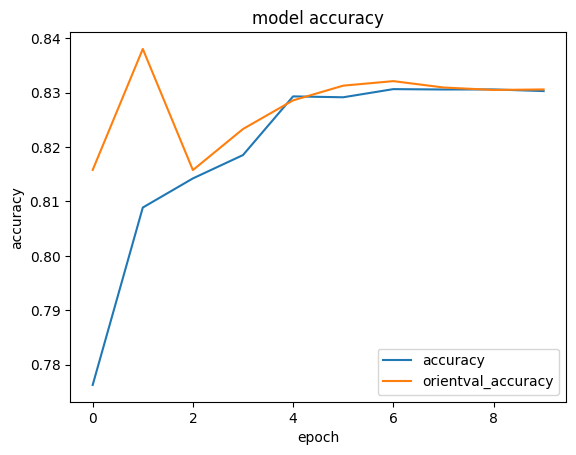

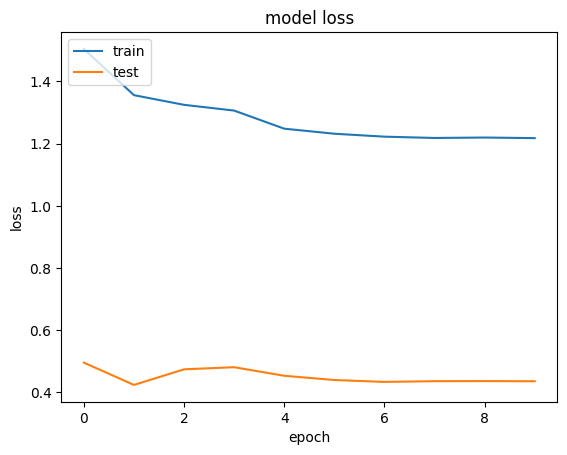

In [14]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_train = model.predict(input_train)
y_pred_test = model.predict(input_test)

3830/3830 [==============================] - 1s 309us/step


In [30]:
print(y_pred_train.shape)
print(1109036*0.25)
print(ntrain)

(1109036, 3)
277259.0
277259


In [32]:
###########################################################
# Reshape the prediction for next network
###########################################################
y_pred_0_train = y_pred_train[0:ntrain].reshape(-1, 1, 3)
print(y_pred_0_train.shape)
y_pred_1_train = y_pred_train[ntrain:(ntrain * 2)].reshape(-1, 1, 3)
print(y_pred_1_train.shape)
y_pred_2_train = y_pred_train[(ntrain * 2):(ntrain * 3)].reshape(-1, 1, 3)
print(y_pred_2_train.shape)
y_pred_3_train = y_pred_train[(ntrain * 3):].reshape(-1, 1, 3)
print(y_pred_3_train.shape)
input_final_train = np.concatenate((y_pred_0_train, y_pred_1_train, y_pred_2_train, y_pred_3_train), axis=1).reshape(-1, 12)

y_pred_0_test = y_pred_test[0:ntest].reshape(-1, 1, 3)
y_pred_1_test = y_pred_test[ntest:(ntest * 2)].reshape(-1, 1, 3)
y_pred_2_test = y_pred_test[(ntest * 2):(ntest * 3)].reshape(-1, 1, 3)
y_pred_3_test = y_pred_test[(ntest * 3):].reshape(-1, 1, 3)
input_final_test = np.concatenate((y_pred_0_test, y_pred_1_test, y_pred_2_test, y_pred_3_test), axis=1).reshape(-1, 12)

(277259, 1, 3)
(277259, 1, 3)
(277259, 1, 3)
(277259, 1, 3)


In [33]:
###########################################################
# Reshape the prediction and truth labels for metrics
###########################################################

pred_individual_links_train = input_final_train.reshape(-1, 3)
y_train = y_train.reshape(-1, 3)

pred_individual_links_test = input_final_test.reshape(-1, 3)
y_test = y_test.reshape(-1, 3)

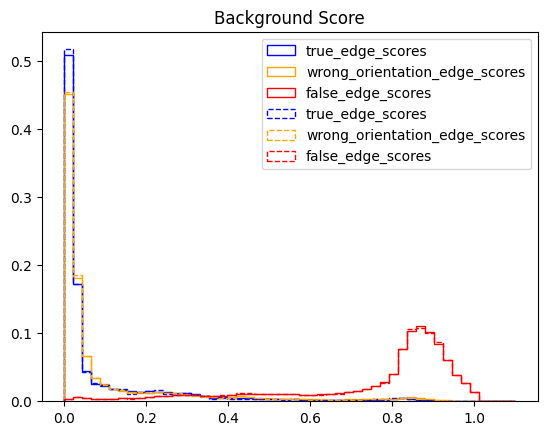

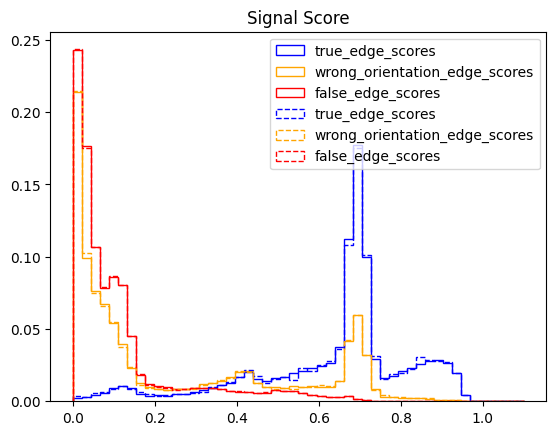

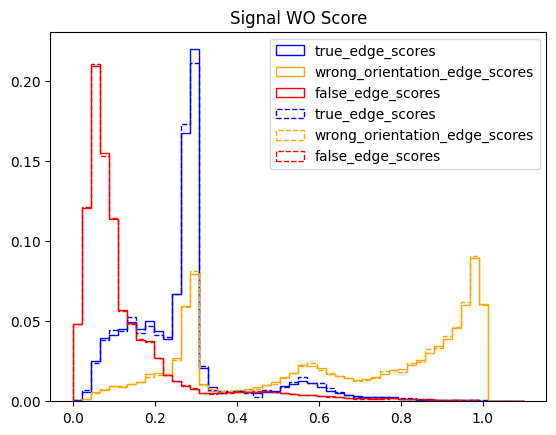

[[79755  6364  5533]
 [  481  6409   837]
 [ 1703  5848 15630]]


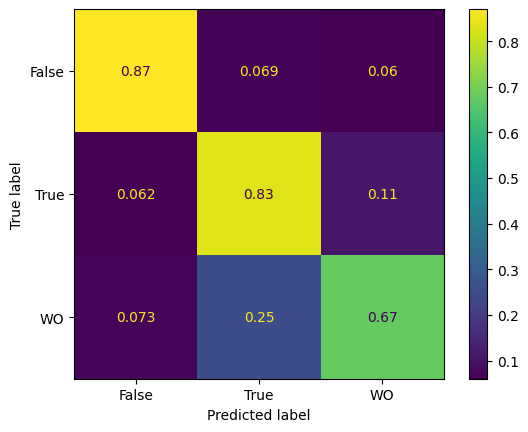

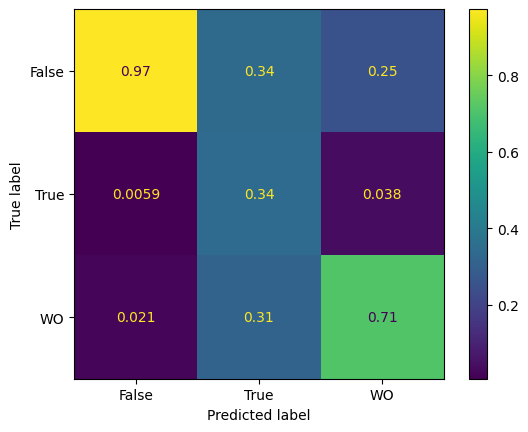

In [34]:
#######################################
# Plot edge scores
#######################################

PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 0)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 1)
PerformanceFuncs.plot_multi(pred_individual_links_train, y_train, pred_individual_links_test, y_test, 2)
PerformanceFuncs.draw_confusion_multi(pred_individual_links_test, y_test)

In [35]:
###########################################################
# Define the model and optimiser and compile the model
###########################################################

model_final = HigherTierModel.HigherTierFinalOutputModel(12, dropoutRate=0.5)
optimiser_final = optimizers.legacy.Adam(learning_rate=learningRate)
model_final.compile(optimizer=optimiser_final, metrics=['accuracy'], loss=['binary_crossentropy'])

In [36]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(trueParentChildLink_train.argmax(axis=1) == 1)
nBackground_final = np.count_nonzero(trueParentChildLink_train.argmax(axis=1) == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('classWeights_final:', classWeights_final)

classWeights_final: {0: 1.0, 1: 3.0183628510971334}


In [37]:
###########################################################
# Reshape for sigmoid training
###########################################################

trueParentChildLink_train = trueParentChildLink_train.argmax(axis=1).reshape((-1,1))
trueParentChildLink_test = trueParentChildLink_test.argmax(axis=1).reshape((-1,1))

In [38]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model_final.fit(input_final_train, trueParentChildLink_train, validation_data=(input_final_test, trueParentChildLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
4243/4333 [============================>.] - ETA: 0s - loss: 0.4336 - accuracy: 0.8934
Epoch 1: val_accuracy improved from -inf to 0.89925, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


4333/4333 [==============================] - 2s 417us/step - loss: 0.4325 - accuracy: 0.8935 - val_loss: 0.2401 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 2/10
4203/4333 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8991
Epoch 2: val_accuracy did not improve from 0.89925
4333/4333 [==============================] - 2s 389us/step - loss: 0.3666 - accuracy: 0.8991 - val_loss: 0.2407 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 3/10
4234/4333 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8994
Epoch 3: val_accuracy improved from 0.89925 to 0.90248, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/models/all_link_model_track_noPrimaries/assets


4333/4333 [==============================] - 2s 407us/step - loss: 0.3661 - accuracy: 0.8995 - val_loss: 0.2353 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 4/10
4239/4333 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8998
Epoch 4: val_accuracy did not improve from 0.90248
4333/4333 [==============================] - 2s 385us/step - loss: 0.3659 - accuracy: 0.8999 - val_loss: 0.2415 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 5/10
4228/4333 [============================>.] - ETA: 0s - loss: 0.3652 - accuracy: 0.9000
Epoch 5: val_accuracy did not improve from 0.90248

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4333/4333 [==============================] - 2s 387us/step - loss: 0.3658 - accuracy: 0.8999 - val_loss: 0.2409 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 6/10
4247/4333 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8997
Epoch 6: val_accuracy did not improve from 0.90248
4333/4333 [====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


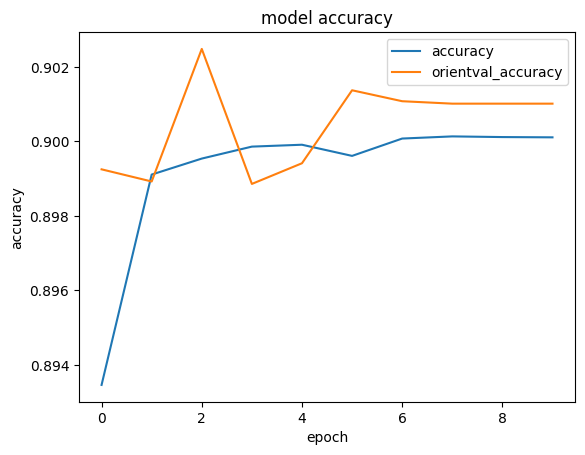

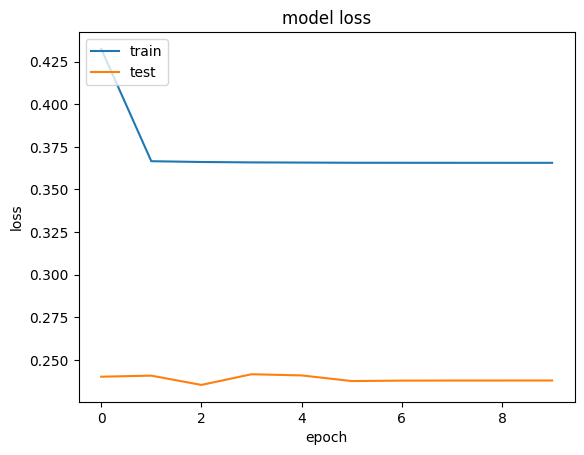

In [39]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'orientval_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model_final.predict(input_final_train)
y_pred_final_test = model_final.predict(input_final_test)

958/958 [==============================] - 0s 246us/step


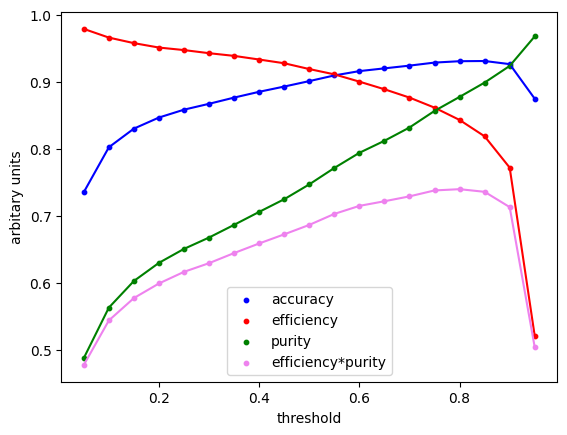

optimal_threshold_metric: 0.8


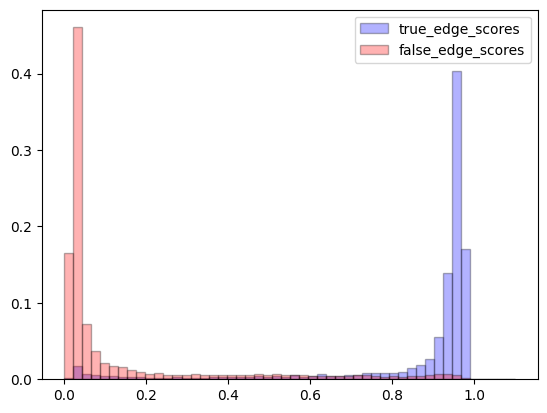

[[20506  2407]
 [  626  7101]]
[[22003   910]
 [ 1213  6514]]


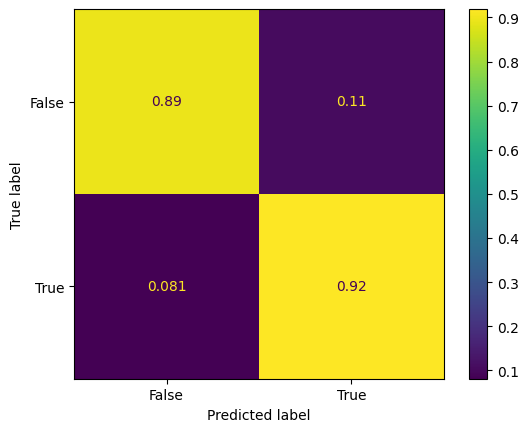

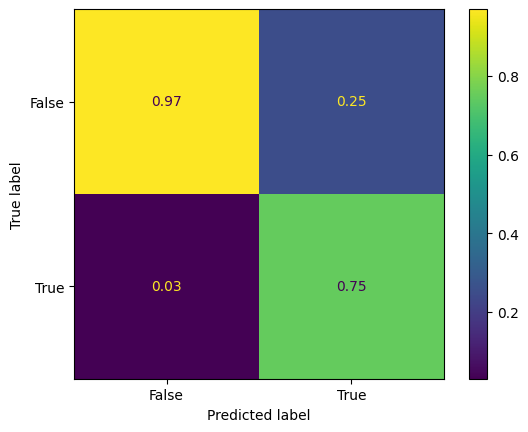

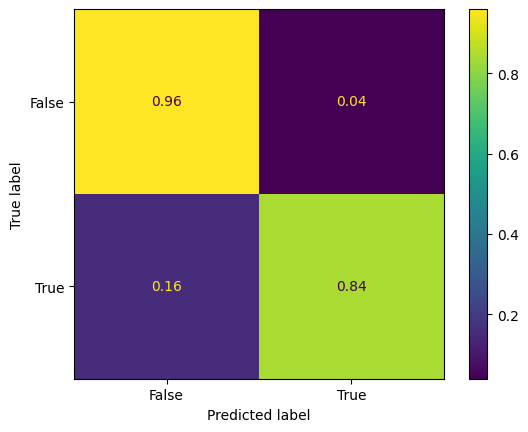

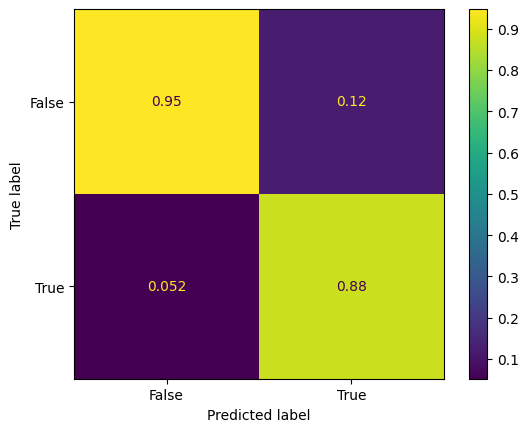

In [41]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, trueParentChildLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, trueParentChildLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, trueParentChildLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, trueParentChildLink_test, optimal_threshold_metric)
